In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def display(img, cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')

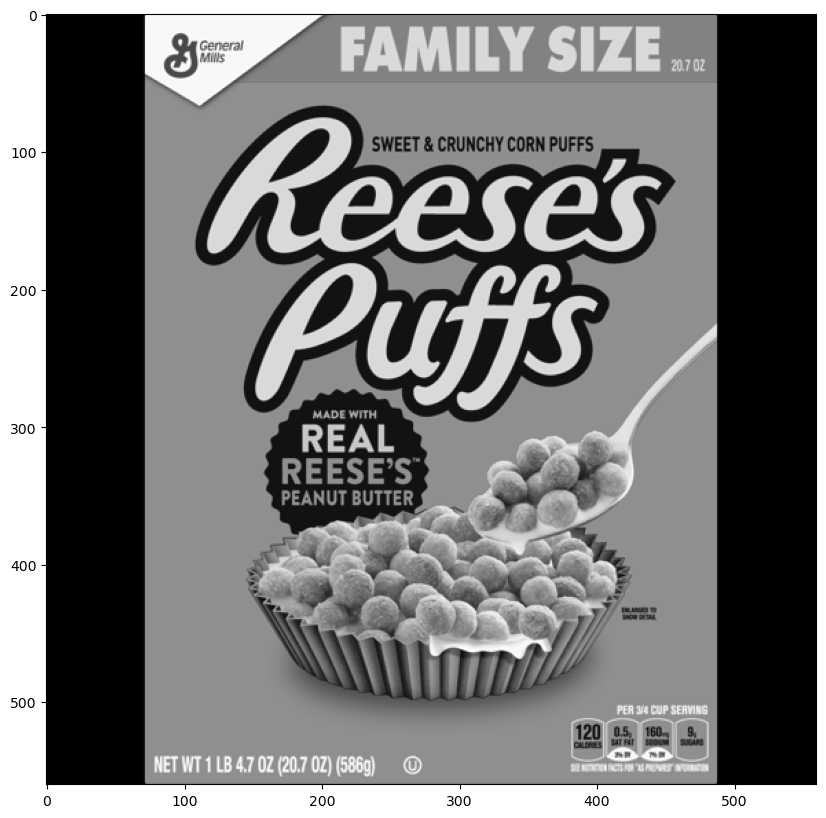

In [3]:
reeses = cv2.imread('../DATA/reeses_puffs.png', 0)
display(reeses)

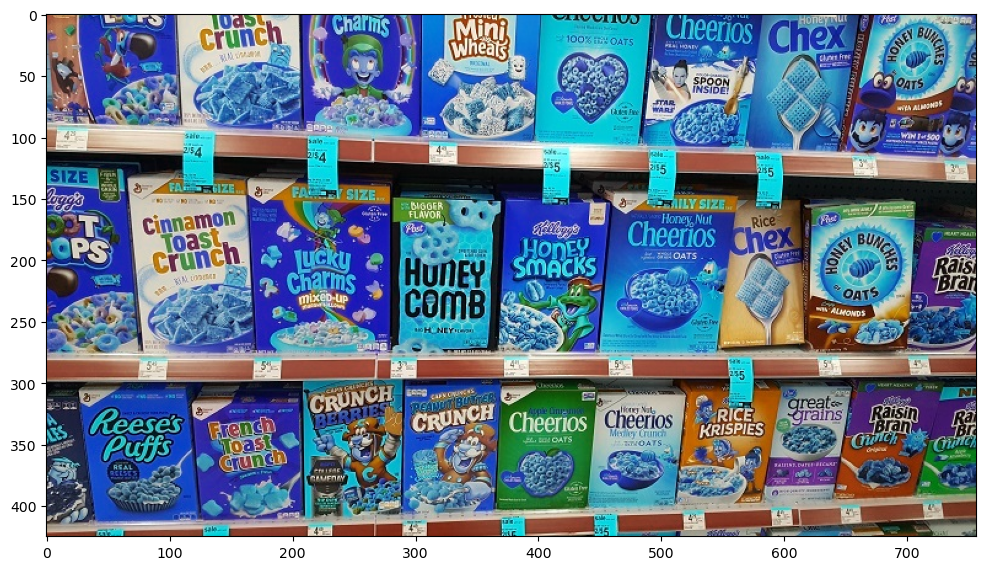

In [4]:
cereals = cv2.imread('../DATA/many_cereals.jpg')
display(cereals)

BRUTE FORCE ORB DESCRIPTORS MATCHER

In [5]:
orb = cv2.ORB_create()

In [6]:
kp1, des1 = orb.detectAndCompute(reeses, None)
kp2, des2 = orb.detectAndCompute(cereals, None)

In [7]:
#Brute force matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

In [8]:
matches = bf.match(des1, des2)

In [9]:
#Each match found in matches gives a distance value to say how similar they are. We want to sort these to find the closest match
single_match = matches[0]
single_match.distance

58.0

In [10]:
matches = sorted(matches, key=lambda x: x.distance)

In [11]:
len(matches)

144

In [12]:
#There are 144 different matches which may be too much to visualize so we are picking the top 25
reeses_matches = cv2.drawMatches(reeses, kp1, cereals, kp2, matches[:25], None, flags=2)

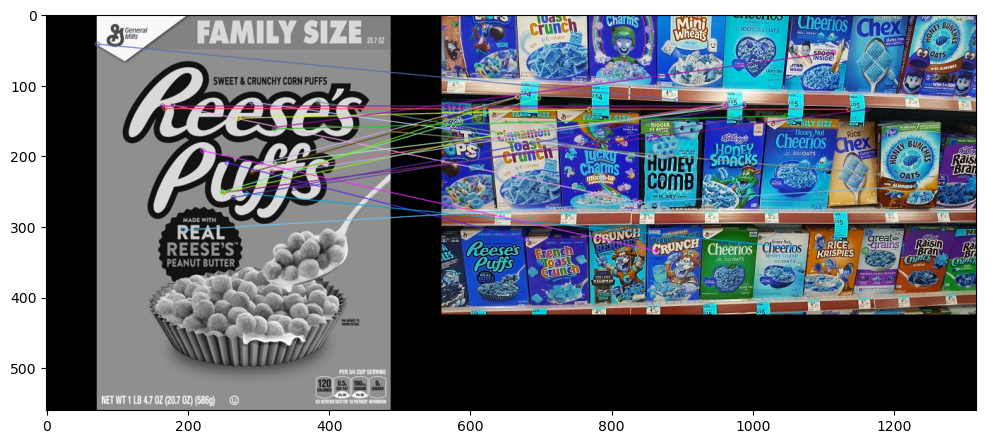

In [13]:
#This one is not very good none of them even point to the reeses box
display(reeses_matches)

In [14]:
#Lets try a SIFT detector
sift = cv2.SIFT_create()

In [15]:
kp1, des1 = sift.detectAndCompute(reeses, None)
kp2, des2 = sift.detectAndCompute(cereals, None)

In [16]:
bf = cv2.BFMatcher()

In [17]:
#This will find te top 2 matches in the matching description vectors
matches = bf.knnMatch(des1, des2, k=2)

In [18]:
matches[0]

(< cv2.DMatch 0x1303136b0>, < cv2.DMatch 0x1301b0f10>)

The left is a match in the reeses image and the right is a match in the cereals image. We will then do a ratio test of these matches to see if they are actually a good match

In [19]:
#LESS DISTANCE == BETTER MATCH

good = []

for match1, match2 in matches:
    #IF MATCH 1 DISTANCE IS LESS THAN 75% OF MATCH 2 DISTANCE
    # THEN DESCRIPTOR WAS A GOOD MATCH, LETS KEEP IT
    if match1.distance < 0.75*match2.distance:
        good.append([match1])

In [20]:
len(good)

75

In [21]:
len(matches)

1501

We found there were 75 good matches in the list of 1501 potential matches

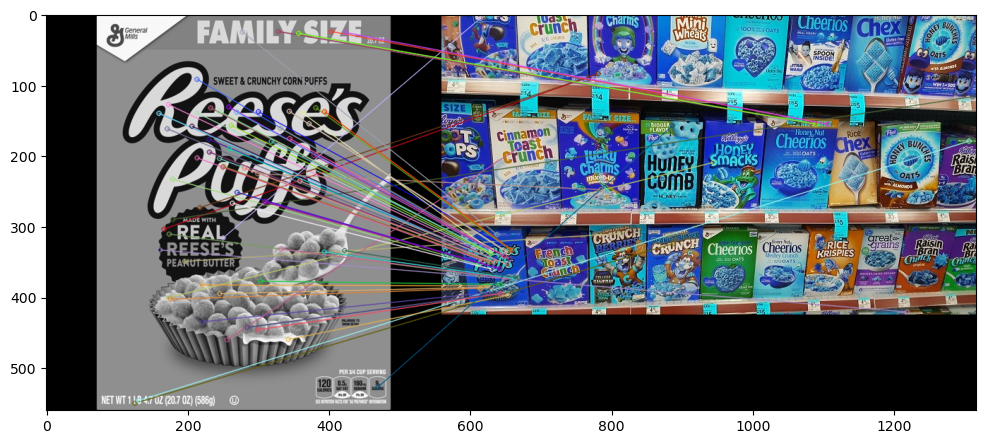

In [22]:
#This matcher did very well, notice the family size that is not in our cereals picture matches well to the family size image on the cheerios
sift_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, good, None, flags=2)
display(sift_matches)

Now lets try a FLANN-based matcher

In [23]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(reeses, None)
kp2, des2 = sift.detectAndCompute(cereals, None)

In [25]:
#FLANN (FAST LIBRARY FOR APPROXIMATE NEAREST NEIGHBORS)
#Advantage is this is much faster than either of the brute force matchers BUT it is only finding approximate nearest neighbors
#So it is finding good matches but not necessarily the best matches
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

In [26]:
flann = cv2.FlannBasedMatcher(index_params, search_params)

In [27]:
matches = flann.knnMatch(des1, des2, k=2)

In [30]:
good = []

for match1, match2 in matches:
    if match1.distance < 0.7 * match2.distance:
        good.append([match1])

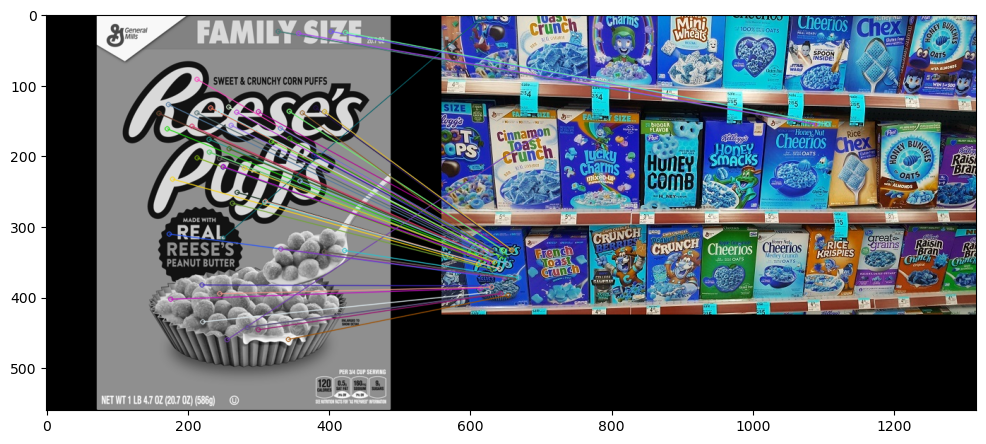

In [32]:
flann_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, good, None, flags=2)
display(flann_matches)

Alternate masking method (all lines up until the matchesMask is the same as above)

In [33]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(reeses, None)
kp2, des2 = sift.detectAndCompute(cereals, None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

In [41]:
#Create a mask with a list of 0's that we will "turn on" in the loop
matchesMask = [[0,0] for i in range(len(matches))]

In [42]:
#Turn on matches by making the 0 switch to a 1
for i,(match1, match2) in enumerate(matches):
    if match1.distance < 0.7 * match2.distance:
        matchesMask[i] = [1,0]

In [43]:
draw_params = dict(matchColor=(0,255,0),
                  singlePointColor=(255,0,0),
                  matchesMask = matchesMask,
                  flags=cv2.DrawMatchesFlags_DEFAULT)

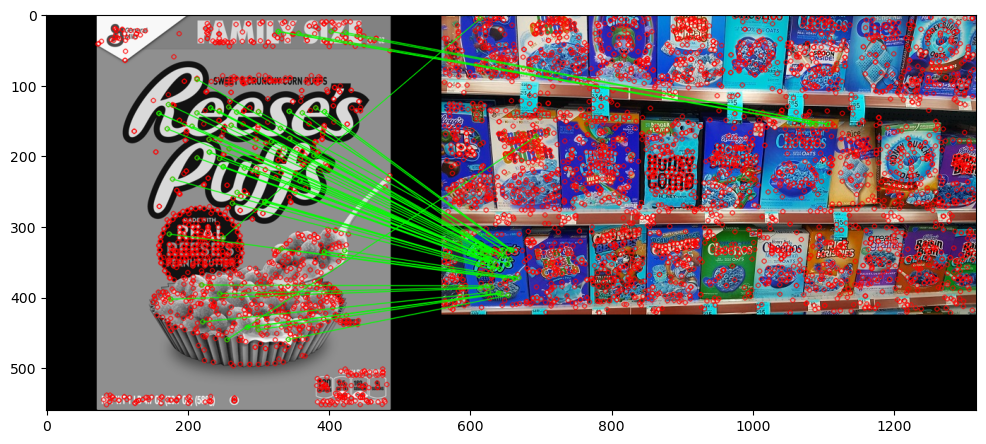

In [48]:
mask_flann_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, matches, None, **draw_params)
display(mask_flann_matches)